## Import the necessary packages

In [112]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sb

import os
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB,BernoulliNB

import re
import emoji

from collections import Counter
from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from nltk import FreqDist
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, CuDNNLSTM, concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D, Dropout, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shaoxing/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shaoxing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Reading dataset 

In [113]:
## reading train set
root="/Users/shaoxing/Desktop/dataset/"
training_dataset = pd.read_csv(root+'offenseval-training-v1.tsv' , sep='\t') 
training_dataset

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH
13238,27429,@USER Pussy,OFF,UNT,NaN


In [114]:
## reading the test set
root="/Users/shaoxing/Desktop/dataset/"
test_data = pd.read_csv(root+'testset-levela.tsv' , sep='\t') 

test_labels=pd.read_csv(root+'labels-levela.csv' , sep='\t') 

test_labels=np.array(test_labels)

test_labels=np.insert(test_labels,0,['15923,OFF'])
labels=[]
for item in test_labels:
    labels.append(item.split(",")[1])


labels=pd.DataFrame(labels, columns=["subtask_a"])

test_dataset = pd.concat([test_data, labels], axis=1)
test_dataset

,id,tweet,subtask_a
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF
1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT
3,13876,#Watching #Boomer getting the news that she is...,NOT
4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF
...,...,...,...
855,73439,#DespicableDems lie again about rifles. Dem Di...,OFF
856,25657,#MeetTheSpeakers 🙌 @USER will present in our e...,NOT
857,67018,3 people just unfollowed me for talking about ...,OFF
858,50665,#WednesdayWisdom Antifa calls the right fascis...,NOT


## Exploration the distribution of training dataset

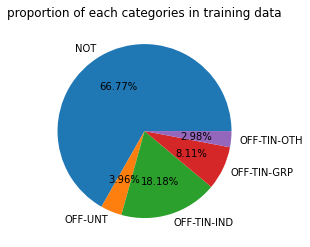

In [115]:
labels=["NOT", "OFF-UNT", "OFF-TIN-IND", "OFF-TIN-GRP","OFF-TIN-OTH"]
NOT=training_dataset.loc[training_dataset["subtask_a"]=="NOT"].shape[0]
OFF_UNT=training_dataset.loc[training_dataset["subtask_b"]=="UNT"].shape[0]
OFF_TIN_IND=training_dataset.loc[training_dataset["subtask_c"]=="IND"].shape[0]
OFF_TIN_GRP=training_dataset.loc[training_dataset["subtask_c"]=="GRP"].shape[0]
OFF_TIN_OTH=training_dataset.loc[training_dataset["subtask_c"]=="OTH"].shape[0]
X=[NOT,OFF_UNT,OFF_TIN_IND,OFF_TIN_GRP,OFF_TIN_OTH]

 
fig = plt.figure()
plt.pie(X,labels=labels,autopct='%1.2f%%')
plt.title("proportion of each categories in training data")
  
plt.show() 

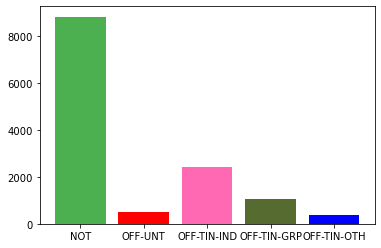

In [116]:
X = np.array(["NOT", "OFF-UNT", "OFF-TIN-IND", "OFF-TIN-GRP","OFF-TIN-OTH"])
NOT=training_dataset.loc[training_dataset["subtask_a"]=="NOT"].shape[0]
OFF_UNT=training_dataset.loc[training_dataset["subtask_b"]=="UNT"].shape[0]
OFF_TIN_IND=training_dataset.loc[training_dataset["subtask_c"]=="IND"].shape[0]
OFF_TIN_GRP=training_dataset.loc[training_dataset["subtask_c"]=="GRP"].shape[0]
OFF_TIN_OTH=training_dataset.loc[training_dataset["subtask_c"]=="OTH"].shape[0]
Y=[NOT,OFF_UNT,OFF_TIN_IND,OFF_TIN_GRP,OFF_TIN_OTH]

Y = np.array(Y)

plt.bar(X, Y,  color = ["#4CAF50","red","hotpink","#556B2F","blue"])
plt.show()

##   Dataset Preprocessing

In [117]:
def emojiPreprocessing(text):
    
    text = emoji.demojize(text)
    
    text = re.compile("([\U0001f3fb-\U0001f3ff])").sub(r'',text) 
    text = re.compile("([\U00010000-\U0010ffff])").sub(r'',text) 
    text = re.compile("(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff])").sub(r'',text)

   
    text = re.compile("([\U00010000-\U0010ffff])").sub(r' \1 ',text) 
    return text

In [118]:
## Dataset Cleaning 

def dataset_cleaning(text):
    
    text = re.compile(r'@USER').sub(r'<user>',text)# Replace @USER by <user>

    text = re.compile(r'URL').sub(r'<url>',text)# Replace URL by <url>

    text = re.compile(r'[0-9]+').sub(r' ',text)# Remove numbers 

    text = re.compile(r'([\xa0_\{\}\[\]¬•$,:;/@#|\^*%().~`”"“-])').sub(r' ',text)# Remove some special characters

    text = re.compile(r'([$&+,:;=?@#|\'.^*()%!"’“-])').sub(r' \1 ',text)# Space the special characters with white spaces

    # Replace some special characters
    replace_dict = {r'&' : 'and' , r'&amp;' : 'and' , 
                    r'\+' : 'plus'}
    for cha in replace_dict:
        text = re.compile(str(cha)).sub(str(replace_dict[cha]),text)

    
    text = emojiPreprocessing(text)# Handle Emoji

    
    text = re.compile(r'(.)\1{3,}').sub(r'\1\1',text)# Word delengthening 

    # Cut the words with caps in them : 
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)        
  
    # TOKENIZE 
    text = text.split(' ')

    # Remove white spaces tokens
    text = [text[i] for i in range(len(text)) if text[i] != ' ']

    # Remove empty tokens
    text = [text[i] for i in range(len(text)) if text[i] != '']

    # Remove repetition in tokens (!!! => !)
    text = [text[i] for i in range(len(text)) if text[i] != text[i-1]]

    #  Handle the ALL CAPS Tweets 
    ### if ratio of caps in the word > 75% add allcaps tag <allcaps>
    caps_r = np.mean([text[i].isupper() for i in range(len(text))])
    if caps_r > 0.6 : 
        text.append('<allcaps>')

    # Lower Case : 
    text = [text[i].lower() for i in range(len(text))]
    
    return " ".join(str(x) for x in text)

In [119]:
## showing the preprocessed tweets
training_dataset['subtask_a'].replace({'NOT':0, 'OFF': 1}, inplace= True)
training_dataset["preprocessed_tweet"] = training_dataset["tweet"].apply(dataset_cleaning)
training_dataset.head()

,id,tweet,subtask_a,subtask_b,subtask_c,preprocessed_tweet
0,86426,@USER She should ask a few native Americans wh...,1,UNT,NaN,<user> she should ask a few native americans w...
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,1,TIN,IND,<user> go home you re drunk ! <user> maga trum...
2,16820,Amazon is investigating Chinese employees who ...,0,NaN,NaN,amazon is investigating chinese employees who ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",1,UNT,NaN,<user> someone should ' ve taken this piece of...
4,43605,@USER @USER Obama wanted liberals &amp; illega...,0,NaN,NaN,<user> obama wanted liberals and amp illegals ...


In [120]:
## showing  the preprocessed tweets test dataset
test_dataset['subtask_a'].replace({'NOT':0, 'OFF': 1}, inplace= True)
test_dataset["preprocessed_tweet"] = test_dataset["tweet"].apply(dataset_cleaning)
test_dataset.head()

,id,tweet,subtask_a,preprocessed_tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,1,who isq wheres the server dump nike declasfisa...
1,27014,"#ConstitutionDay is revered by Conservatives, ...",0,constitution day is revered by conservatives h...
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,0,fox news nra maga potus trump nd amendment rnc...
3,13876,#Watching #Boomer getting the news that she is...,0,watching boomer getting the news that she is s...
4,60133,#NoPasaran: Unity demo to oppose the far-right...,1,no pasaran unity demo to oppose the far right ...


Count the most frequent words in the offensive tweets

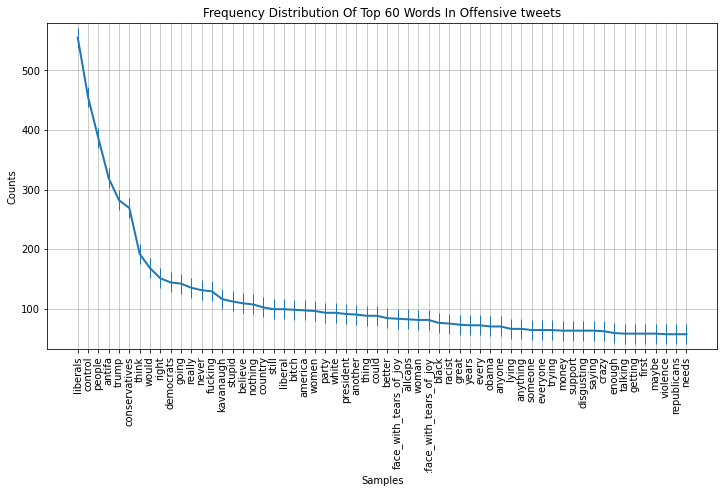

In [121]:
offensive_language = training_dataset.loc[training_dataset['subtask_a'] == 1].values
len(offensive_language)
offensive_language[0][1]

stop_words = set(stopwords.words('english'))
word_tokens = [word_tokenize(question[5]) for question in offensive_language]


all_words = [word for question in word_tokens for word in question]
len(all_words)
without_stopwords = [w for w in all_words if not w in stop_words]
words_len = [w for w in without_stopwords if not len(w)<5]
freq_dist = FreqDist([word for word in words_len])

plt.figure(figsize=(12,6))
plt.title(f'Frequency Distribution Of Top 60 Words In Offensive tweets')
freq_dist.plot(60, marker='|', markersize=20)
plt.show()

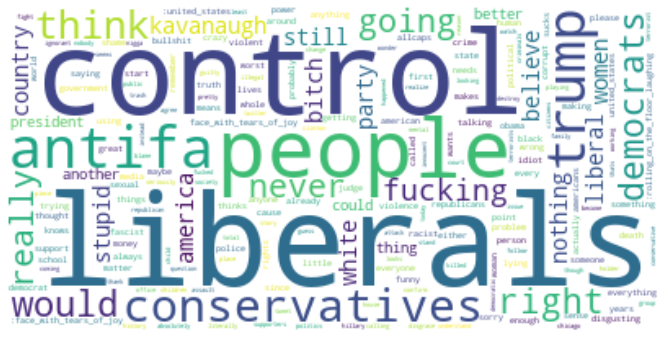

In [11]:
##show the word cloud of most frequency in offensive tweets (Top 60)
wordcloud = WordCloud(background_color='White').generate_from_frequencies(freq_dist)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Features Extraction

In [12]:
Tweets = training_dataset["preprocessed_tweet"].values
labels = training_dataset["subtask_a"].values


In [16]:
train_Tweets=training_dataset["preprocessed_tweet"].values
train_labels=training_dataset["subtask_a"].values


test_Tweets=test_dataset["preprocessed_tweet"].values
test_labels=test_dataset["subtask_a"].values

In [18]:
unique, counts = np.unique(train_labels, return_counts=True)
print(np.asarray((unique, counts)).T)
unique, counts = np.unique(test_labels, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 8840]
 [   1 4400]]
[[  0 620]
 [  1 240]]


## Features Extraction: TFIDF

In [21]:
def tf_idf(Tweets, train_Tweets, test_Tweets):
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(Tweets)

    train_text_features_tf = tfidf_vectorizer.transform(train_Tweets)
    test_text_features_tf = tfidf_vectorizer.transform(test_Tweets)
    
    return train_text_features_tf, test_text_features_tf


## Features Extraction:CountVectorizer

In [42]:
def count(Tweets, train_Tweets, test_Tweets):
    
    count_vectorizer = CountVectorizer()
    count_vectorizer.fit(Tweets)

    train_text_features_cv = count_vectorizer.transform(train_Tweets)
    test_text_features_cv = count_vectorizer.transform(test_Tweets)
    
    return train_text_features_cv, test_text_features_cv

## Sampling: Undersampling

In [55]:
def undersampling(train_text_features_tf, train_labels):
    randomUnderSampler = RandomUnderSampler(random_state=0)
    Tweets_resampled, labels_resampled = randomUnderSampler.fit_resample(train_text_features_tf, train_labels)
    return Tweets_resampled, labels_resampled

## Sampling: Oversampling

In [56]:
def oversampling(train_text_features_tf, train_labels):
    smote = SMOTE('minority')
    Tweets_oversampled, labels_oversampled = smote.fit_resample(train_text_features_tf, train_labels)
    return Tweets_oversampled, labels_oversampled

## Plotting Confusion Matrix

In [45]:
def confusionMatrix(labels_test, labels_pred):
    
    mat = confusion_matrix(labels_test, labels_pred)
    cm = pd.DataFrame(mat)
    TP = cm.iloc[1,1] # True Positive
    TN = cm.iloc[0,0] # True Negative
    FP = cm.iloc[0,1] # False Positive
    FN = cm.iloc[1,0] # False Negative

    print('Sensitivity: {:.2%}'.format(TP/(FN+TP)))
    print('Specificity: {:.2%}'.format(TN/(FP+TN)))
  
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
    plt.title('A confusion matrix showing the frequency of misclassifications by our classifier')
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    plt.show()

## Modeling

In [52]:
def modelBuild(model, Tweets, train_Tweets, train_labels, test_Tweets, test_labels, tfidf = False, cv = False, undersampled = False, oversample = False):

    if tfidf:
        print('Feature Extraction using TFIFD')
        train_text_features, test_text_features = tf_idf(Tweets, train_Tweets, test_Tweets)
    
    if cv:
        print('Feature Extraction using CountVectorizer')
        train_text_features, test_text_features = count(Tweets, train_Tweets, test_Tweets)
        
    if undersampled:
        print('Undersampling dataset')
        train_text_features, train_labels = undersampling(train_text_features, train_labels)
        
    if oversample:
        print('Oversampling dataset')
        train_text_features, train_labels = oversampling(train_text_features, train_labels)
           
    model.fit(train_text_features, train_labels)
    predictions = model.predict(test_text_features)

    # Use accuracy_score function to get the accuracy
    print("Accuracy Score -> ",accuracy_score(predictions, test_labels)*100)
    print('F1Score', f1_score(predictions, test_labels, average="macro"))
    print('Precision', precision_score(predictions, test_labels, average="macro"))
    print('Recall', recall_score(predictions, test_labels, average="macro"))

    confusionMatrix(test_labels, predictions)
    

## SVM: Count and Original dataset 

Feature Extraction using CountVectorizer
Accuracy Score ->  76.3953488372093
F1Score 0.7032360495615175
Precision 0.7009408602150538
Recall 0.7057825587237352
Sensitivity: 55.83%
Specificity: 84.35%


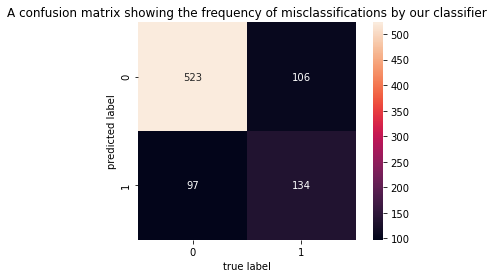

In [53]:
modelBuild(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = False, cv = True, undersampled = False, oversample = False)

## SVM: Count and Undersampling

Feature Extraction using CountVectorizer
Undersampling dataset
Accuracy Score ->  75.5813953488372
F1Score 0.7154220451795079
Precision 0.7323252688172044
Recall 0.7070754264903201
Sensitivity: 67.92%
Specificity: 78.55%


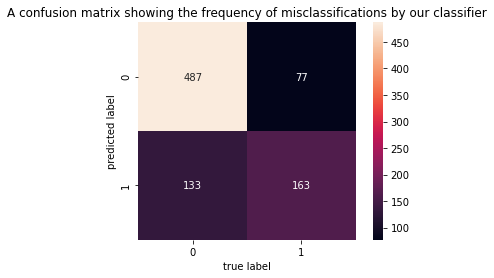

In [57]:
modelBuild(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = False, cv = True, undersampled = True, oversample = False)

## SVM: Count and Oversampling

Feature Extraction using CountVectorizer
Oversampling dataset


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


Accuracy Score ->  71.27906976744185
F1Score 0.6553855538376927
Precision 0.6616263440860215
Recall 0.6512778417275238
Sensitivity: 54.58%
Specificity: 77.74%


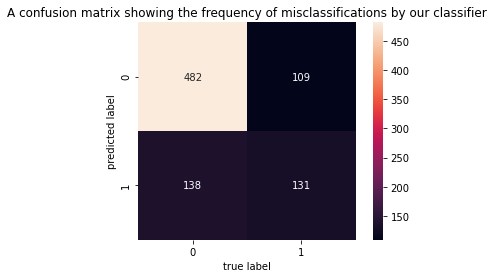

In [58]:
modelBuild(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = False, cv = True, undersampled = False, oversample = True)

## SVM: TFIDF and Original data

Feature Extraction using TFIFD
Accuracy Score ->  82.20930232558139
F1Score 0.7411060544350196
Precision 0.7144489247311827
Recall 0.8184026980911803
Sensitivity: 47.08%
Specificity: 95.81%


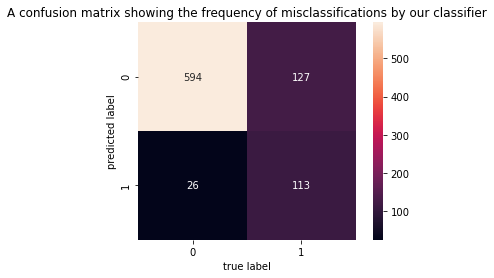

In [59]:
modelBuild(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = True, cv = False, undersampled = False, oversample = False)

## SVM: TFIDF and Undersampling

Feature Extraction using TFIFD
Undersampling dataset
Accuracy Score ->  76.51162790697674
F1Score 0.73003885003885
Precision 0.7528225806451613
Recall 0.7206451612903226
Sensitivity: 72.50%
Specificity: 78.06%


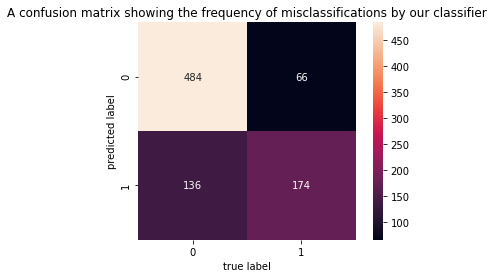

In [60]:
modelBuild(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = True, cv = False, undersampled = True, oversample = False)

## SVM: TFIDF and Oversampling

Feature Extraction using TFIFD
Oversampling dataset


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


Accuracy Score ->  79.30232558139535
F1Score 0.741481801723905
Precision 0.740255376344086
Recall 0.7427612994350282
Sensitivity: 62.08%
Specificity: 85.97%


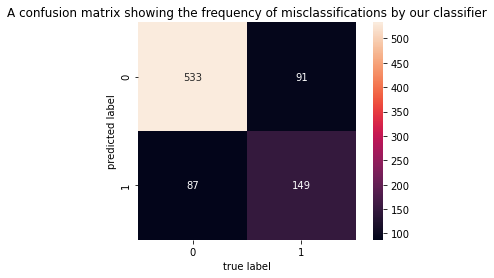

In [61]:
modelBuild(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = True, cv = False, undersampled = False, oversample = True)

## Random Forest: Count and Original data

Feature Extraction using CountVectorizer
Accuracy Score ->  72.44186046511628
F1Score 0.43211548266840527
Precision 0.50625
Recall 0.8617269544924153
Sensitivity: 1.25%
Specificity: 100.00%


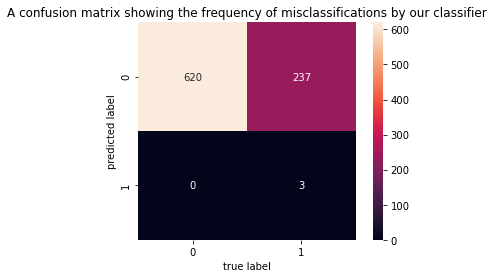

In [62]:
modelBuild(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = False, cv = True, undersampled = False, oversample = False)

## Random Forest: Count and Undersampling 

Feature Extraction using CountVectorizer
Undersampling dataset
Accuracy Score ->  75.0
F1Score 0.6897437575403678
Precision 0.6899865591397849
Recall 0.6895038845950168
Sensitivity: 55.42%
Specificity: 82.58%


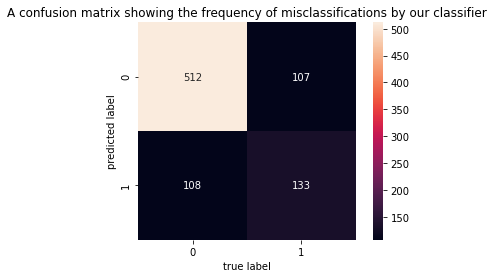

In [63]:
modelBuild(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = False, cv = True, undersampled = True, oversample = False)

## Random Forest: Count and Oversampling

Feature Extraction using CountVectorizer
Oversampling dataset


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


Accuracy Score ->  71.16279069767441
F1Score 0.6081111870585555
Precision 0.6020833333333333
Recall 0.6251276813074566
Sensitivity: 35.42%
Specificity: 85.00%


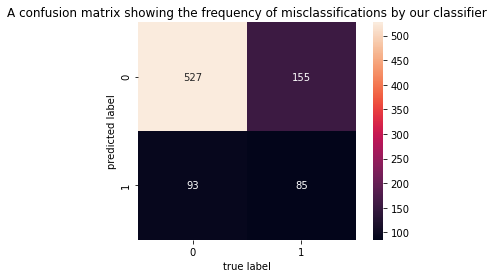

In [64]:
modelBuild(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = False, cv = True, undersampled = False, oversample = True)

## Random Forest: TFIDF and Original data

Feature Extraction using TFIFD
Accuracy Score ->  72.32558139534883
F1Score 0.42775025442020154
Precision 0.5041666666666667
Recall 0.8613053613053613
Sensitivity: 0.83%
Specificity: 100.00%


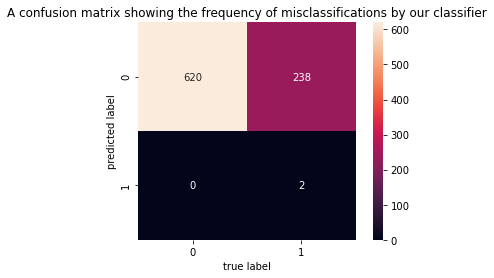

In [65]:
modelBuild(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = True, cv = False, undersampled = False, oversample = False)

## Random Forest: TFIDF and Undersampling

Feature Extraction using TFIFD
Undersampling dataset
Accuracy Score ->  70.81395348837209
F1Score 0.6648755897590353
Precision 0.6826612903225806
Recall 0.6591903431553424
Sensitivity: 62.50%
Specificity: 74.03%


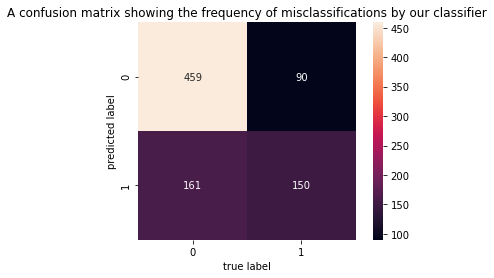

In [66]:
modelBuild(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = True, cv = False, undersampled = True, oversample = False)

## Random Forest: TFIDF and Oversampling

Feature Extraction using TFIFD
Oversampling dataset


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


Accuracy Score ->  74.4186046511628
F1Score 0.6256015704154002
Precision 0.6157258064516129
Recall 0.6748862528436789
Sensitivity: 32.50%
Specificity: 90.65%


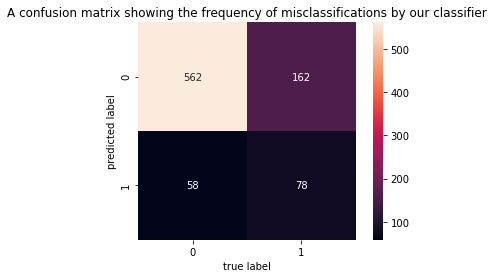

In [67]:
modelBuild(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = True, cv = False, undersampled = False, oversample = True)

### Deep Learning

In [79]:
## split dataset into training set and validation set
training_Tweets, val_Tweets, training_labels, val_labels = train_test_split(train_Tweets, train_labels, stratify=train_labels, test_size=0.2)


## Tokenize tweets

In [86]:
max_features = 50000 
maxlen = 100


tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(training_Tweets))
training_Tweets = tokenizer.texts_to_sequences(training_Tweets)
val_Tweets = tokenizer.texts_to_sequences(val_Tweets)
test_Tweets = tokenizer.texts_to_sequences(test_Tweets)

## Padding the tweets

In [89]:
training_Tweets = pad_sequences(training_Tweets, maxlen=maxlen)
test_Tweets = pad_sequences(test_Tweets, maxlen=maxlen)
val_Tweets = pad_sequences(val_Tweets, maxlen=maxlen)

In [90]:
S_DROPOUT = 0.4
DROPOUT = 0.1

In [91]:
## plotting function
def plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show() 

## Model Build: LSTM and Keras

In [92]:
embed_size = 100

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          5000000   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         84480     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0     

Epoch 1/15
166/166 [==============================] - 22s 112ms/step - loss: 0.6032 - accuracy: 0.6922 - val_loss: 0.5142 - val_accuracy: 0.7587
Epoch 2/15
166/166 [==============================] - 18s 109ms/step - loss: 0.4230 - accuracy: 0.8126 - val_loss: 0.5157 - val_accuracy: 0.7613
Epoch 3/15
166/166 [==============================] - 18s 109ms/step - loss: 0.2786 - accuracy: 0.8925 - val_loss: 0.6468 - val_accuracy: 0.7379
Epoch 4/15
166/166 [==============================] - 18s 109ms/step - loss: 0.1774 - accuracy: 0.9364 - val_loss: 0.7643 - val_accuracy: 0.7315
Epoch 5/15
166/166 [==============================] - 18s 110ms/step - loss: 0.1127 - accuracy: 0.9628 - val_loss: 0.9738 - val_accuracy: 0.7345
Epoch 6/15
166/166 [==============================] - 18s 111ms/step - loss: 0.0770 - accuracy: 0.9755 - val_loss: 1.0609 - val_accuracy: 0.7239
Epoch 7/15
166/166 [==============================] - 18s 111ms/step - loss: 0.0583 - accuracy: 0.9820 - val_loss: 1.2299 - val_ac

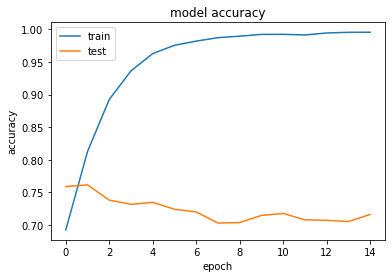

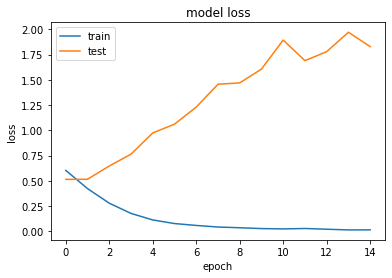

Test Accuracy: 75.116277


In [93]:
history = model.fit(training_Tweets, training_labels, batch_size=64, epochs=15, validation_data=(val_Tweets, val_labels))
plot(history)

loss, accuracy = model.evaluate(test_Tweets, test_labels, verbose=0)
print('Test Accuracy: %f' % (accuracy*100))

In [95]:
pred_val_labels = model.predict([val_Tweets], batch_size=1024, verbose=1)

3/3 [==============================] - 1s 221ms/step


In [98]:
## search for the best threshold
thresholds = []
for thresh in np.arange(0.1, 1.0, 0.01):
    thresh = np.round(thresh, 2)
    res = metrics.f1_score(val_labels, (pred_val_labels > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh)

F1 score at threshold 0.1 is 0.5451327433628318
F1 score at threshold 0.11 is 0.5459940652818991
F1 score at threshold 0.12 is 0.5439330543933054
F1 score at threshold 0.13 is 0.5431654676258993
F1 score at threshold 0.14 is 0.539987973541792
F1 score at threshold 0.15 is 0.539529269764635
F1 score at threshold 0.16 is 0.536969696969697
F1 score at threshold 0.17 is 0.5358444714459296
F1 score at threshold 0.18 is 0.5365853658536586
F1 score at threshold 0.19 is 0.5345565749235474
F1 score at threshold 0.2 is 0.5336597307221542
F1 score at threshold 0.21 is 0.5339865278628292
F1 score at threshold 0.22 is 0.5331695331695333
F1 score at threshold 0.23 is 0.5311152187307454
F1 score at threshold 0.24 is 0.5306122448979592
F1 score at threshold 0.25 is 0.530359355638166
F1 score at threshold 0.26 is 0.5285359801488834
F1 score at threshold 0.27 is 0.5282784338098198
F1 score at threshold 0.28 is 0.5284197376639599
F1 score at threshold 0.29 is 0.528160200250313
F1 score at threshold 0.3 i

In [99]:
pred_test_labels = model.predict([test_Tweets], batch_size=1024, verbose=1)
pred_test_labels =  (pred_test_labels > best_thresh).astype(int)

unique, counts = np.unique(pred_test_labels, return_counts=True)
print(np.asarray((unique, counts)).T)

1/1 [==============================] - 0s 261ms/step
[[  0 635]
 [  1 225]]


Sensitivity: 49.58%
Specificity: 82.90%


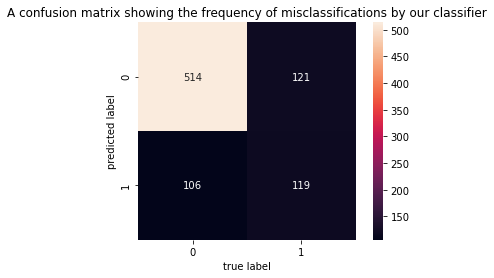

In [100]:
confusionMatrix(test_labels, pred_test_labels)

In [102]:
print(f1_score(pred_test_labels, test_labels, average="macro"))
print(precision_score(pred_test_labels, test_labels, average="macro"))
print(recall_score(pred_test_labels, test_labels, average="macro"))

0.6654757314826714
0.6624327956989247
0.6691688538932633


## Model Build: LSTM and GloVe Embeddings

In [103]:
from numpy import asarray

embed_size = 200

embeddings_index = dict()
f = open(root+'glove.twitter.27B.200d.txt', encoding="utf8")
for line in f:
    
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [104]:
from numpy import zeros

embedding_matrix = zeros((max_features, embed_size))
for word, i in tokenizer.word_index.items():
    
    
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        embedding_matrix[i] = embedding_vector

In [105]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 200)          10000000  
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 128)         135680    
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0   

Epoch 1/15
166/166 [==============================] - 32s 174ms/step - loss: 0.5488 - accuracy: 0.7289 - val_loss: 0.4665 - val_accuracy: 0.7851
Epoch 2/15
166/166 [==============================] - 27s 165ms/step - loss: 0.4117 - accuracy: 0.8197 - val_loss: 0.4597 - val_accuracy: 0.7900
Epoch 3/15
166/166 [==============================] - 28s 167ms/step - loss: 0.3292 - accuracy: 0.8619 - val_loss: 0.5022 - val_accuracy: 0.7813
Epoch 4/15
166/166 [==============================] - 28s 170ms/step - loss: 0.2386 - accuracy: 0.9090 - val_loss: 0.5471 - val_accuracy: 0.7583
Epoch 5/15
166/166 [==============================] - 28s 169ms/step - loss: 0.1539 - accuracy: 0.9453 - val_loss: 0.6851 - val_accuracy: 0.7730
Epoch 6/15
166/166 [==============================] - 28s 170ms/step - loss: 0.0977 - accuracy: 0.9691 - val_loss: 0.8137 - val_accuracy: 0.7519
Epoch 7/15
166/166 [==============================] - 28s 169ms/step - loss: 0.0635 - accuracy: 0.9813 - val_loss: 0.9906 - val_ac

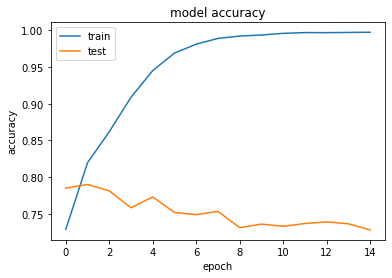

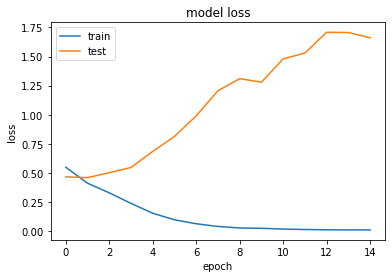

Test Accuracy: 76.279068


In [108]:
history = model.fit(training_Tweets, training_labels, batch_size=64, epochs=15, validation_data=(val_Tweets, val_labels))
plot(history)

loss, accuracy = model.evaluate(test_Tweets, test_labels, verbose=0)
print('Test Accuracy: %f' % (accuracy*100))

In [109]:
## search for the best parameters
pred_val_labels = model.predict([val_Tweets], batch_size=1024, verbose=1)


thresholds = []
for thresh in np.arange(0.1, 0.5, 0.01):
    thresh = np.round(thresh, 2)
    res = metrics.f1_score(val_labels, (pred_val_labels > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh)

3/3 [==============================] - 2s 297ms/step
F1 score at threshold 0.1 is 0.5943396226415095
F1 score at threshold 0.11 is 0.5933719095213046
F1 score at threshold 0.12 is 0.5933368588048652
F1 score at threshold 0.13 is 0.5927889713679746
F1 score at threshold 0.14 is 0.5930666666666666
F1 score at threshold 0.15 is 0.5930666666666666
F1 score at threshold 0.16 is 0.5913229780396357
F1 score at threshold 0.17 is 0.591715976331361
F1 score at threshold 0.18 is 0.5929919137466306
F1 score at threshold 0.19 is 0.5912290200324851
F1 score at threshold 0.2 is 0.5906623235613464
F1 score at threshold 0.21 is 0.5900925421883506
F1 score at threshold 0.22 is 0.5886214442013129
F1 score at threshold 0.23 is 0.5889436234263821
F1 score at threshold 0.24 is 0.5875892366831411
F1 score at threshold 0.25 is 0.5863586358635864
F1 score at threshold 0.26 is 0.5846662989520133
F1 score at threshold 0.27 is 0.584070796460177
F1 score at threshold 0.28 is 0.5834719911259013
F1 score at threshol

1/1 [==============================] - 0s 325ms/step
Sensitivity: 63.75%
Specificity: 79.35%


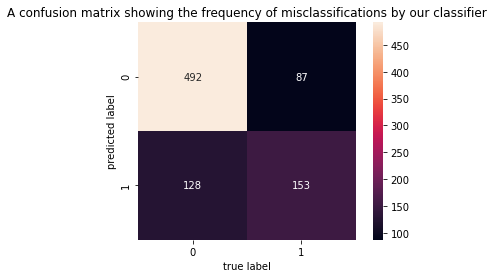

In [110]:
pred_test_labels = model.predict([test_Tweets], batch_size=1024, verbose=1)
pred_test_labels = (pred_test_labels > best_thresh).astype(int)

unique, counts = np.unique(pred_test_labels, return_counts=True)
#print(np.asarray((unique, counts)).T)
confusionMatrix(test_labels, pred_test_labels)

In [111]:
print(f1_score(pred_test_labels, test_labels, average="macro"))
print(precision_score(pred_test_labels, test_labels, average="macro"))
print(recall_score(pred_test_labels, test_labels, average="macro"))

0.7040079784977564
0.7155241935483871
0.6971124592038058
